In [25]:
import mlflow
import mlflow.sklearn
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
main_folder = './data/Training_data'

img_train = []

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientMRI') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            img_train.append(data)

mask_train = []
for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientContour') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            mask_train.append(data)

In [3]:
main_folder = './data/Validation_data'

img_vad = []

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientMRI') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            img_vad.append(data)
            
mask_vad = []

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientMRI') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            mask_vad.append(data)


In [18]:
main_folder = './data/Testing_data'

img_test = []

for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientMRI') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            img_test.append(data)

mask_test = []
for root, dirs, files in os.walk(main_folder):
    for file in files:
        if file.startswith('patientContour') and file.endswith('.npy'):
            file_path = os.path.join(root, file)
            data = np.load(file_path)
            mask_test.append(data)

In [19]:
print(len(img_train), len(mask_train))
print(len(img_vad), len(mask_vad))
print(len(img_test), len(mask_test))

260 260
266 266
15 15


In [5]:
img_train = np.array(img_train)
mask_train = np.array(mask_train)
img_vad = np.array(img_vad)
mask_vad = np.array(mask_vad)

In [6]:
print(np.shape(img_train))

(260, 112, 112, 1)


In [26]:
mlflow.sklearn.autolog()
mlflow.set_experiment('Mlops_project_model')

2023/06/02 17:42:46 INFO mlflow.tracking.fluent: Experiment with name 'Mlops_project_model' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Admin/Documents/MLOPS%20Project/mlruns/852499338127039584', creation_time=1685709766977, experiment_id='852499338127039584', last_update_time=1685709766977, lifecycle_stage='active', name='Mlops_project_model', tags={}>

In [7]:
# importing all the necessary libraries for UNET
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator,  
from keras_preprocessing.image import img_to_array, array_to_img, img_to_array,load_img
# from tensorflow.keras.utils import img_to_array
from keras.utils.vis_utils import plot_model

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # adding first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # adding second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [9]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)   # convolutional layer
    p1 = MaxPooling2D((2, 2))(c1)                                                         # Max pooling layer
    p1 = Dropout(dropout)(p1)                                                             # Dropout 
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)        # Transposed convolutional layer
    u6 = concatenate([u6, c4])                                                                 # concatenation leyer
    u6 = Dropout(dropout)(u6)                                                                  # Dropout layer
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)               # convolutional layer
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)                                     # applying sigmoid on last layer
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
# im_width = 112
# im_height = 112
# input_img = Input((im_height, im_width, 1), name='img')
# model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 112, 112, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

                                                                                                  
 batch_normalization_13 (BatchN  (None, 28, 28, 64)  256         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 28, 28, 64)   0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 56, 56, 32)  18464       ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 56, 56, 64)   0           ['conv2d_transpose_2[0][0]',     
          

In [12]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

In [13]:
def Train_function(model, train_images,train_mask, validation_images, validation_maks, batch_size, epoch,callbacks ):
  print("Training ")
  results = model.fit(train_images, train_mask, batch_size=batch_size, epochs=epoch, callbacks=callbacks,\
                    validation_data=(validation_images, validation_maks))
  return results

In [14]:
epoch = 5
batch_size = 32
results = Train_function(model, img_train, mask_train, img_vad, mask_vad, batch_size, epoch, callbacks)

Training 
Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7976
Epoch 1: val_loss improved from inf to 10.01393, saving model to model-tgs-salt.h5
9/9 [==============================] - 19s 2s/step - loss: 0.5393 - accuracy: 0.7976 - val_loss: 10.0139 - val_accuracy: 0.0023 - lr: 0.0010
Epoch 2/5
9/9 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.9131
Epoch 2: val_loss improved from 10.01393 to -1586.55054, saving model to model-tgs-salt.h5
9/9 [==============================] - 18s 2s/step - loss: 0.3953 - accuracy: 0.9131 - val_loss: -1586.5505 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 3/5
9/9 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9659
Epoch 3: val_loss did not improve from -1586.55054
9/9 [==============================] - 20s 2s/step - loss: 0.2821 - accuracy: 0.9659 - val_loss: -814.4042 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 4/5
9/9 [==============================] - ETA: 0s - loss:

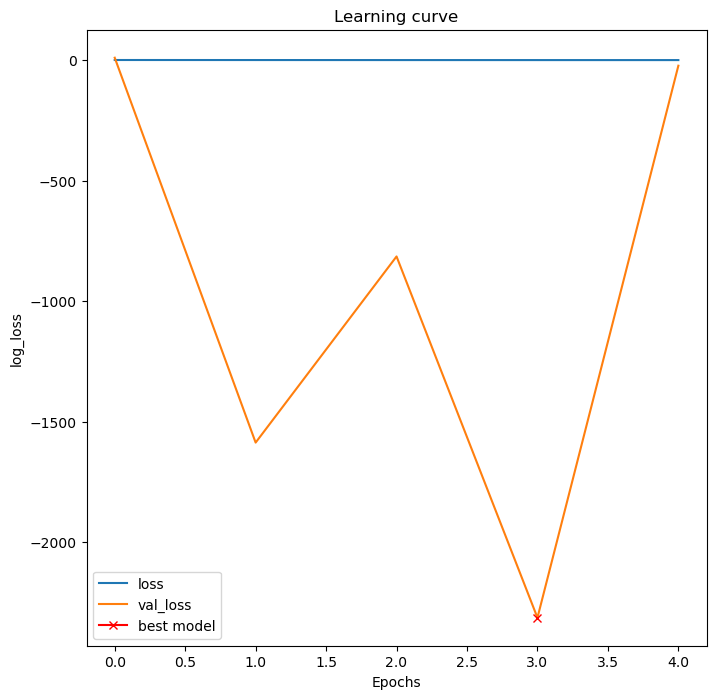

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [34]:
accuracy, loss = [], []
for i in range(len(mask_test)):
    preds_mask = model.predict(img_test[i], verbose=1)
    preds_mask_t = (preds_mask > 0.5).astype(np.uint8)
    evaluation_ = model.evaluate(mask_test[i], preds_mask_t, verbose=1)
    loss.append(evaluation_[0])
    accuracy.append(evaluation_[1])
avg_accuracy= sum(accuracy)/len(accuracy)
avg_loss= sum(loss)/len(loss)

1/1 [==============================] - 0s 233ms/step - loss: 0.4634 - accuracy: 0.8291


In [35]:
avg_accuracy, avg_loss

(0.7739106376965841, 0.5236129264036814)

In [36]:
hyperparams = {
        'learning_rate': [0.00001, 0.0001, 0.000001],
        'dropout': [0.05, 0.07, 0.04]
    }
desc ="UNET model training"

# Iterate over all hyperparameter combinations
for learning_rate_i in hyperparams['learning_rate']:
    for dropout_i in hyperparams['dropout']:
        # Start a nested run with the current hyperparameters
        with mlflow.start_run(run_name="mlops_project_example",description=desc):
            im_width = 112
            im_height = 112
            input_img = Input((im_height, im_width, 1), name='img')
            model = get_unet(input_img, n_filters=16, dropout=dropout_i, batchnorm=True)
            model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
            
            
            callbacks = [
                EarlyStopping(patience=10, verbose=1),
                ReduceLROnPlateau(factor=0.1, patience=5, min_lr=learning_rate_i, verbose=1),
                ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
            ]


            epoch = 2
            batch_size = 32
            results = Train_function(model, img_train, mask_train, img_vad, mask_vad, batch_size, epoch, callbacks)
            
            
            accuracy, loss = [], []
            for i in range(len(mask_test)):
                preds_mask = model.predict(img_test[i], verbose=1)
                preds_mask_t = (preds_mask > 0.5).astype(np.uint8)
                evaluation_ = model.evaluate(mask_test[i], preds_mask_t, verbose=1)
                loss.append(evaluation_[0])
                accuracy.append(evaluation_[1])
            avg_accuracy= sum(accuracy)/len(accuracy)
            avg_loss= sum(loss)/len(loss)
            

            mlflow.log_metric('accuracy', avg_accuracy)
            


Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.2937
Epoch 1: val_loss improved from inf to -2122.57153, saving model to model-tgs-salt.h5
9/9 [==============================] - 19s 2s/step - loss: 0.9095 - accuracy: 0.2937 - val_loss: -2122.5715 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5673
Epoch 2: val_loss improved from -2122.57153 to -25722.04102, saving model to model-tgs-salt.h5
1/1 [==============================] - 0s 272ms/step - loss: 0.3593 - accuracy: 0.9485
Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.8933 - accuracy: 0.2655
Epoch 1: val_loss improved from inf to -277.19080, saving model to model-tgs-salt.h5
9/9 [==============================] - 21s 2s/step - loss: 0.8933 - accuracy: 0.2655 - val_loss: -277.1908 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 0.

1/1 [==============================] - 0s 251ms/step - loss: 0.7617 - accuracy: 0.2410
Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.6683
Epoch 1: val_loss improved from inf to -302.02167, saving model to model-tgs-salt.h5
9/9 [==============================] - 21s 2s/step - loss: 0.6453 - accuracy: 0.6683 - val_loss: -302.0217 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.8606
Epoch 2: val_loss did not improve from -302.02167
1/1 [==============================] - 0s 251ms/step - loss: 0.5017 - accuracy: 0.8201
Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.5309
Epoch 1: val_loss improved from inf to -1596.55652, saving model to model-tgs-salt.h5
9/9 [==============================] - 19s 2s/step - loss: 0.7293 - accuracy: 0.5309 - val_loss: -1596.5565 - val_accuracy: 0.0021 - lr: 0.0010
Epoch 2/2
9/9 [==========

1/1 [==============================] - 0s 267ms/step - loss: 0.1268 - accuracy: 0.9623
Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.6741
Epoch 1: val_loss improved from inf to 274.17560, saving model to model-tgs-salt.h5
9/9 [==============================] - 19s 2s/step - loss: 0.6344 - accuracy: 0.6741 - val_loss: 274.1756 - val_accuracy: 0.0023 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8686
Epoch 2: val_loss improved from 274.17560 to -2321.18579, saving model to model-tgs-salt.h5
1/1 [==============================] - 0s 286ms/step - loss: 0.9836 - accuracy: 0.1077
Training 
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.6360
Epoch 1: val_loss improved from inf to -130.49521, saving model to model-tgs-salt.h5
9/9 [==============================] - 19s 2s/step - loss: 0.6565 - accuracy: 0.6360 - val_loss: -130.4952 - val_accuracy: 0.0022 

1/1 [==============================] - 0s 278ms/step - loss: 0.3130 - accuracy: 0.9373


In [42]:
!mlflow ui
# Runs on http://localhost:5000/

^C


In [40]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("Mlops_project_model").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.accuracy"])


In [41]:
all_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.note.content,tags.mlflow.runName
0,ca422e7182174138aad5b76598e2f94f,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 13:00:51.018000+00:00,2023-06-02 13:01:33.454000+00:00,0.104303,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
1,ea81c750ed1a4b2fb51c0e0463755074,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:57:52.887000+00:00,2023-06-02 12:58:38.621000+00:00,0.218805,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
2,d2b21f8b8e2c43e18ee8368ae870e2a7,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:59:24.833000+00:00,2023-06-02 13:00:07.615000+00:00,0.703507,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
3,98728426ff73484a9e0029e2852046a7,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 13:01:33.466000+00:00,2023-06-02 13:02:16.025000+00:00,0.752542,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
4,836f6dda8f1e491eade21051e33724f3,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:57:07.198000+00:00,2023-06-02 12:57:52.879000+00:00,0.799738,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
5,2930ab21ef734a658b8487729e582c20,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:58:38.622000+00:00,2023-06-02 12:59:24.824000+00:00,0.823855,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
6,a18aecb0a4c74cfaa670f899a748c722,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 13:02:16.025000+00:00,2023-06-02 13:02:59.063000+00:00,0.936866,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
7,9fc717f1b18f4a389304cb05417bb908,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 13:00:07.623000+00:00,2023-06-02 13:00:51.018000+00:00,0.959990,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
8,29cd9d133d0d480bb81577ccbbdc354c,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:56:24.008000+00:00,2023-06-02 12:57:07.193000+00:00,0.968221,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example


In [46]:
all_runs[-1:]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.note.content,tags.mlflow.runName
8,29cd9d133d0d480bb81577ccbbdc354c,852499338127039584,FINISHED,file:///C:/Users/Admin/Documents/MLOPS%20Proje...,2023-06-02 12:56:24.008000+00:00,2023-06-02 12:57:07.193000+00:00,0.968221,Admin,C:\Users\Admin\anaconda3\lib\site-packages\ipy...,LOCAL,UNET model training,mlops_project_example
